Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

---

### Monte-Carlo transport project
Simulate electron transport in a cylindrical Geiger counter filled 
with Helium gas.

This project attempts to simulate the microscopic transport of electrons in Helium gas under the influence of an electric field. The challenge for this modelling task is to implement the physics of electron-atom scattering with the kinematics of the Lorentz force on an electron in an electric field. Scattering is a quantum process which takes place probabilistically depending on the kinetic energy of the charge. However, this kinetic energy depends on the discrete step in time the program decides to take since the electric field keeps accelerating the electron. 

The contradiction between the requirement for a constant, discrete time step and a probabilitic waiting time step, i.e. the time to the next scattering reaction as a function of kinetic energy, is solved by the null-collision simulation method. A description of the method can be found below. Find all technical requirements for the code below.

- Write a function **run(charges, voltage)** that starts the simulation and returns (a) a list of lists of arrays of electron interaction locations in 3D in order to draw the required scatterplot, see below and (b) a list of total transport times for every electron. Input **charges** is a list of a single array with the starting position of the first electron (in 3D) and represents the charge pool container (the list) to store all electron starting locations that have not yet been transported. The **voltage** input is a number that needs to reach the electric field calculation function (for you to write) for flexibility in the simulation configuration.

- Geometry: Let the cylindrical Geiger counter long axis be defined along the z-axis. Set the anode wire with radius 8.0e-5 m at the origin; the cathode cylinder radius is 1.0e-2 m and the anode bias is set at 1000 Volt. Start a single electron at a radial distance of 3.0e-3 m.

- Transport should be simulated using the null-collision method. A pseudo-code demonstrating the method is shown and discussed below.

- Electrons can scatter elastically or ionize the gas using inelastic scattering. Each ionization should increase the number  of electrons to transport by one (store it in the charge pool). The original electron which requires further, subsequent, transport should carry on after ionization (however, see condition below). The two cross section functions have been pre-coded for you. A function randomly choosing between the processes as a function of energy in eV is also given.

- In case of elastic scattering, simply change (i.e. rotate) the velocity vector direction randomly in the forward hemisphere, i.e. towards the wire, and leave the magnitude unchanged. The only velocity magnitude (and direction) changes in the entire code should arise from acceleration due to the electric field. That 'forward' scattering statement is an arbitrary, simple, requirement. Forward scattering in electron-atom interactions is dominant but the angular distributions (which we would realistically need here) are complicated hence ignore them here.

- The case of an inelastic collision should reset the electron velocity vector to thermal energy (0.025 eV), set the dynamic null collision constant `kv=0` (see below) and store the location of the electron in the charge pool (identical to creating an additional electron since the original carries on being transported) for later transport.

- Count all interactions for all electrons and store all inelastic collision locations and 1 in 1000 elastic collision locations. Otherwise, there will be too many collisions to store and to draw! The model solution produced between 7-11 thousand electrons in test runs with the given conditions, each with thousands of interaction locations stored.

- Suppress single electron starting positions from the pool of charges closer than 5e-4 m: 

```python
if math.hypot(pos[0], pos[1]) < 5.0e-4: # block avalanche at rad=5.0e-4 m
    places.append(pos)
    stopFlag = True`
```
    
assuming the location vector 'pos' is created from the charge pool container and 'stopFlag' is the boolean checked for the transport `while` loop. This suppression should keep execution time of your pure python code below 90 minutes (on my humble 4-core machine), hopefully.

#### Marking
As always for Python projects, find the correct solution first, optimize second. A correct figure indicates a successful code hence attracts 15 out of 20 marks (with the caveat of checking the code for correctness, of course, including subtraction of marks for mistakes along the way). The final 5 marks are awarded for speed of code execution.
- Draw a scatterplot of electron transport interactions. The picture should reveal the electron avalanche near the wire for full marks on graphics.

- This simulation benefits greatly from efforts to speed up the execution. On the assessment workstation (4-cores) a speed-up factor between 20-30 has been achieved comparing the pure python version with an optimized version. Full marks will be awarded for any speed-up factor of 10 or more compared to the pure python model solution. Clearly, the given cross section functions are also available for optimization in order to reach such speed-ups. They are being called millions of times after all. Therefore, please print(!) the process time of your `run(charges, voltage)` function for a manual assessment using

```python
start = time.process_time()
res, times = run(single, bias) # just example variable names, choose as you wish
stop = time.process_time()
print('Process time: ', (stop-start))
``` 

- In case no full marks can be awarded according to the items above, partial marks will be awarded manually, depending on how many required parts of the full code have been completed.

### Null collision method and coding hints
The function transporting a single electron should contain the null collision method set up

```python
kmax = 2.0e-12 # null collision constant
tau = 1.0 / (nDensity * kmax)
```

with nDensity the number density of the gas following from the Helium density
`density = 0.1664 # [kg/m^3] NTP He gas at 293 K`
and 'tau' the time constant of the null collision method. The 'tau' constant is required in the time update function (for you to code).

`time_update = -tau * math.log(random.random())`

which yields in the single electron transport `while` loop a new `time_step=time_update` proposal. Remember to add up the individual time steps in case no collision has taken place and the electron remains in free flight.

With that proposal, the velocity vector should be updated, a new kinetic energy calculated and the corresponding cross section determined. Then the null collision decision must be take. For that calculate

`kv = np.linalg.norm(v0) * cross_section`

where cross_section results from the `cross_section(energy)` function already in the correct SI units. Note that the call to the cross section function already decides whether an inelastic collision takes place. Therefore that case can be dealt with immediately. If that is not the case, then take the (elastic) collision decision

```python
prob = random.random()
if prob <= (kv/kmax): # collision takes place
```

Deal with the collision and prepare the next step, see below, and finally return to the start of the while loop for the next step.

One crucial action to take once a collision takes place, is to advance the electron position to a new location. Change the velocity vector direction (not magnitude!) random-isotropically in the forward hemisphere (not realistic but simple) and evaluate the electric field at that place. The latter is a good place to check for a geometry boundary to stop the transport, i.e. signal the `while` to stop. That electric field vector is required in your update of the velocity, see above. 

This velocity update is an approximation (null collision means, without a collision we do not care where the electron is, just that is in free flight) since we pretend that the electron is still at the last known location while we let it fly freely. However, it is an excellent approximation and not a problem as new collisions occur in nanometre distances.

Final tip: the electric field is radially symmetric around the wire anode and points away from the wire, while the Coulomb  force on the electron points in the opposite direction. The Coulomb force determines the velocity vector to add(!) to the current one, given a time_step according to simple, non-relativistic kinematics. The constant electric charge over electron mass in SI units should be used here to retain SI units throughout (keep the electric field strength in Volt/m). The formula for the electric field calculation can be researched in most textbooks on the subject.


Total number of electrons transported: 8185
Runtime for Simulation:
	In Seconds: 44.171875	In Minutes: 0.7361979166666667


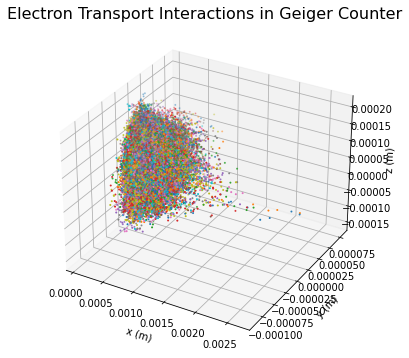

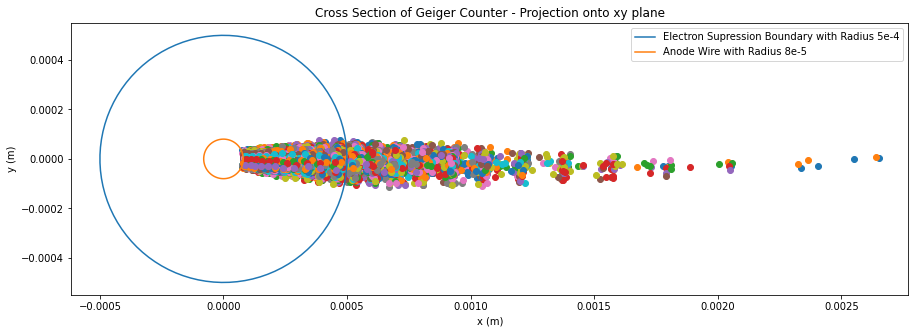

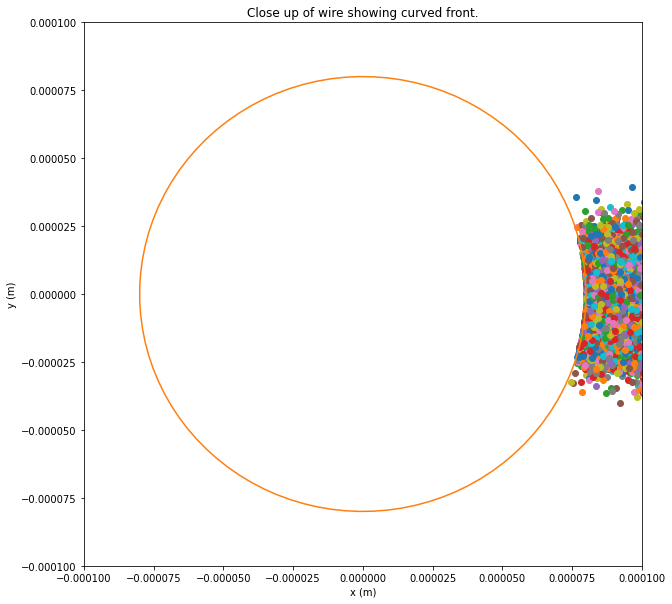

Runtime for Plotting:
	In Seconds: 121.34375	In Minutes: 2.0223958333333334


In [ ]:
'''
    Tom Corley - 2008321
    No Collaborators
'''

# === Imports === 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit

# === Cross Section Functions (optimised from template) === 

# Optimised elastic cross section function
@njit
def eCS_opt(energy): 
    if energy <= 2.0:
        return 7.0e-16
    elif 2.0 < energy <= 10.0:
        return energy * (-0.27231e-16) + 6.455375e-16
    elif 10.0 < energy <= 20.0:
        return energy * (-0.20977e-16) + 6.8801e-16
    elif 20.0 < energy <= 100.0:
        return energy * (-0.02981e-16) + 3.2809e-16
    else:
        return 3.0e-17  # Default value for energy > 100.0

# Optimised inelastic cross section function
@njit
def iCS_opt(energy):
    slope = 0.047745e-17
    intercept = -1.174527e-17
    threshold = 24.6  # [eV]
    max_cs = 3.6e-17  # Constant max [cm^2]

    if energy < threshold:
        return 0  # cs is 0 below the threshold
    elif energy > 100.0:
        return max_cs  # cs is constant above 100.0 eV
    else:
        return energy * slope + intercept

# Optimised cross section function
@njit
def cS_opt(energy):
    elastic = eCS_opt(energy) * 1.0e-4  # Convert to [m^2]
    inel = iCS_opt(energy) * 1.0e-4  # Convert to [m^2]
    inel_flag = inel > 0.0
    total_cs = inel + elastic

    # Compute the ratio for inelastic collision probability, and determine if it occurs
    ratio = inel / total_cs
    inel_collision = np.random.random() < ratio

    # Calculate the cross-section if inelastic collision does not occur
    elastic_cs = 0.0 if inel_collision else elastic

    return inel_collision, elastic_cs

# === Other Functions ===

# Function to calculate electric field strength for a given radial distance and anode voltage
@njit
def calculate_electric_field_strength(r, voltage, r_anode=8.0e-5, r_cathode=1.0e-2, log_ratio = 4.828313737302301):  
    if r_anode < r < r_cathode:
        return voltage / (log_ratio * r)
    else:
        return 0  # Outside the cathode or inside the anode, the electric field is negligible

# Function to efficiently generate a random time step
@njit
def update_time(tau):
    return -tau * np.log(np.random.rand())

# Function to efficiently update velocity
@njit
def update_velocity(x, y, v, electric_field_strength, time_step, charge_over_mass = 1.758820024e11):
    acc_magnitude = charge_over_mass * electric_field_strength
    radial_unit = np.array([-x, -y, 0])
    acceleration = radial_unit * acc_magnitude 
    return np.add(v, acceleration * time_step)

# Function to calculate kinetic energy of an electron with a given speed.
@njit
def update_energy(s, m_e = 9.1093837e-31, J_to_eV = 1 / (1.602e-19)):
    return 0.5 * m_e * (s**2) * J_to_eV

# Function to scatter velocity direction in forward (radially inward) hemisphere following elastic collision 
@njit
def forward_hemisphere_scatter(x_1, x_2, s):
    # Marsaglia algorithm for random point on unit sphere
    while True:
        a, b = np.random.uniform(-1, 1, 2)
        c = a**2 + b**2
        if c < 1:
            break
    factor = 2 * np.sqrt(1 - c)
    y_1 = a * factor
    y_2 = b * factor
    y_3 = 1 - 2 * c

    # Scale to magnitude of velocity
    new_v = s * np.array([y_1, y_2, y_3])

    # Flip if in wrong hemisphere, checked using dot product (z=0)
    if (x_1*y_1 + x_2*y_2) < 0: # Radially inwards, so < 0 means pointing towards origin, not outwards like position
        return new_v
    else: 
        return np.negative(new_v)

# Function to simulate the transport of one electron, and return the interaction locations, new charges, and transport time
@njit
def null_collision_transport(pos, tau, transport_time = 0, kmax = 2.0e-12, therm_speed = 93771.6936957396):
    # Work out initial position related data
    pos_xy = pos[:2]
    r = np.linalg.norm(pos_xy) # Radial distance 
    x = pos[0] / r # These help speed up what would have been vector operations in 3D
    y = pos[1] / r
    v = np.array([0.0, 0.0, 0.0])
    electric_field_strength = calculate_electric_field_strength(r, voltage) 

    # Initialise variables
    new_charges = []
    interactions = []
    time_step = 0

    while True: 
        # STEP 1 *** Generate a proposed time update, add this to the total time step ***
        time_update = update_time(tau)
        time_step += time_update

        # STEP 2 *** Updating electron velocity and energy ***
        v = update_velocity(x, y, v, electric_field_strength, time_update) 
        s = np.linalg.norm(v)
        energy = update_energy(s)

        # STEP 3 *** Detemining collision probabilities with cross section function ***
        inel_flag, elastic_cs = cS_opt(energy) 
        kv = s * elastic_cs 

        # STEP 4 *** Process collisions and advance electron position, return if electron hits wire
        if inel_flag:
            # Update time, position and related quantities, checking for collision in wire, and whether to create a charge
            kv = 0
            pos = np.add(pos, v*time_step)
            pos_xy = pos[:2]
            r = np.linalg.norm(pos_xy)
            x = pos[0] / r
            y = pos[1] / r
            transport_time += time_step
            time_step = 0
            if r > 8e-5:
                interactions.append(pos.copy())
            else: # If electron has hit wire, return
                return new_charges, interactions, transport_time
            if r > 5e-4:
                new_charges.append(pos.copy()) 

            # Work out field strength, reset velocity to thermal energy
            electric_field_strength = calculate_electric_field_strength(r, voltage)
            v = np.array([-therm_speed*x, -therm_speed*y, 0.0])

        # Otherwise decide if an elastic collision should take place, store 1/1000
        elif np.random.rand() <= (kv / kmax):
            # Update position and time, check for collision with wire
            pos = np.add(pos, v*time_step)
            transport_time += time_step
            time_step = 0 
            pos_xy = pos[:2]
            x = pos[0] / r
            y = pos[1] / r
            r = np.linalg.norm(pos_xy)
            if r < 8e-5: # If electron has hit wire, return 
                return new_charges, interactions, transport_time
            
            # Provided electron hasn't yet hit wire, scatter velocity, calculate new field strength, store 1/1000 collisions
            electric_field_strength = calculate_electric_field_strength(r, voltage)
            v = forward_hemisphere_scatter(x, y, s) 
            if np.random.rand() <= 0.001: # Store 1 in 1000 Collisions
                interactions.append(pos.copy())

        # If no collision occurs, do nothing, electron is in 'free flight', time step increases cumulatively
        
# Main function, carrys out the simulation given inputs voltage and charges, returns list of interaction locations, and list of transport times
def run(charges, voltage):
    # === SETUP ===
    density = 0.1664  # [kg/m^3] NTP He gas at 293 K
    molar_mass = 4.002602 / 1000  # Molar mass of Helium in kg/mol
    avogadro_number = 6.022e23  # Avogadro's number
    nDensity = density / molar_mass * avogadro_number 
    kmax = 2.0e-12 
    tau = 1.0 / (nDensity * kmax)
    interaction_locations = []
    total_transport_times = []
    electron_count = 0
    
    # ===== SIMULATING EACH ELECTRON =====
    while electron_count < len(charges):
        # Get charge location and suppress if starting within 5e^-4, increment counter
        pos = np.array(charges[electron_count])
        electron_count += 1
        if np.linalg.norm(pos[:2]) <= 5.0e-4:
            continue

        # === Null Collision Simulation of Electron Transport ===
        new_charges, interactions, transport_time = null_collision_transport(pos, tau=tau)
        
        # Updating Arrays
        charges = np.vstack([charges] + new_charges)
        interaction_locations.append(interactions)
        total_transport_times.append(transport_time)

    # === PRINTING/RETURNING ===
    print(f"Total number of electrons transported: {electron_count}")
    return interaction_locations, total_transport_times

# Function to visualise results of simulation after it has taken place
def plot_interactions(interaction_locations): 
    # Plot 1: 3D Scatterplot of Electron Interaction Locations
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize = (6,6))
    ax.set_title("Electron Transport Interactions in Geiger Counter", size=16)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")

    for interactions in interaction_locations:
        if interactions:  # Check if there are interactions
            interactions = np.array(interactions)
            ax.scatter(interactions[:, 0], interactions[:, 1], interactions[:, 2], s=1)
    #ax.view_init(elev=15, azim=45)
    plt.show()

    # Second Plot, 2D Projection onto xy plane, cross section of cylinder. plt.figure(figsize=(12, 6)) 
    plt.figure(figsize = (15,5))
    for interactions in interaction_locations:
        if interactions:  # Check if there are interactions
            interactions = np.array(interactions)
            plt.scatter(interactions[:, 0], interactions[:, 1])

    radius1 = 5e-4
    theta = np.linspace(0, 2 * np.pi, 100)
    x1 = radius1 * np.cos(theta)
    y1 = radius1 * np.sin(theta)
    radius2 = 8e-5
    x2 = radius2 * np.cos(theta)
    y2 = radius2 * np.sin(theta)
    plt.plot(x1, y1, label=f'Electron Supression Boundary with Radius 5e-4')
    plt.plot(x2, y2, label=f'Anode Wire with Radius 8e-5')
    plt.title("Cross Section of Geiger Counter - Projection onto xy plane")
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()

    # Third Plot: Close-up
    # Second Plot, 2D Projection onto xy plane, cross section of cylinder. plt.figure(figsize=(12, 6)) 
    plt.figure(figsize = (10,10))
    for interactions in interaction_locations:
        if interactions:  # Check if there are interactions
            interactions = np.array(interactions)
            plt.scatter(interactions[:, 0], interactions[:, 1])

    radius1 = 5e-4
    theta = np.linspace(0, 2 * np.pi, 100)
    x1 = radius1 * np.cos(theta)
    y1 = radius1 * np.sin(theta)
    radius2 = 8e-5
    x2 = radius2 * np.cos(theta)
    y2 = radius2 * np.sin(theta)
    plt.plot(x1, y1, label=f'Electron Supression Boundary with Radius 5e-4')
    plt.plot(x2, y2, label=f'Anode Wire with Radius 8e-5')
    plt.title("Close up of wire showing curved front.")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.xlim(-1e-4, 1e-4)
    plt.ylim(-1e-4, 1e-4)
    plt.show()

# === Simulation ===

# Customisable Setup
single_charge_start = np.array([[3e-3, 0, 0]])  # Starting position of a single electron !!!! CHANGED !!!!!!!
voltage = 1000  # Anode set to 1000V

# Running and timing simulation
start = time.process_time()
res, times = run(single_charge_start, voltage)
stop = time.process_time()
print(f"Runtime for Simulation:\n\tIn Seconds: {stop - start}\tIn Minutes: {(stop - start)/60}")

# Plotting results and output of runtime
start2 = time.process_time()
plot_interactions(res)
stop2 = time.process_time()
print(f"Runtime for Plotting:\n\tIn Seconds: {stop2 - start2}\tIn Minutes: {(stop2 - start2)/60}")

## Comments on Optimisation

My strategy for optimisation was made up of two main approaches. The first was the use of numpy functions, so that code was vectorised, and pre-compiled, paticularly for handling the co-ordinate arrays. The second involved the use of the No-python just-in-time compiler njit from the peformance optimisation library numba. Some adjustment was needed to the code, as the range of functions supported by this library is limited. Numpy arrays were not always optimal, as they are less dynamic, and end up being slower to append to in some cases, so the outer arrays in my code such as the one for storing all interaction locations are raw python lists. All of these changes combined already lead to a speedup of at least 10x.

Following this, the main performance bottleneck for this simulation was the scattering of the vector in the case of an elastic collision. I originally attempted to generate random angles and then use a rotation matrix and lots of trigonometry to rotate the velocity vector, but this was extremely computationally expensive. I then did some research into generating random points on a Sphere and found the Marsaglia Algorithm online (https://dodona.be/en/activities/1733299555/). It quite ingeniously only uses 2 random number generations, and uses no trigonometry, or vector operations. The original implementation of this saved a massive amount of time. I could then use a dot product to check whether it was in the right hemisphere, and flip it if necessary. This was optimised further by noticing that since the radial vector had no vertical component (z=0), checking the sign of $x_1x_2 + y_1y_2$ was sufficient, which was much faster than a np.dot call on two vectors in $\R^{3}$. With the redesign of the scattering function, a significant speedup was again achieved, with the simulation code often running in under a minute.